<a href="https://colab.research.google.com/github/NSR9/EVA8/blob/main/pytorch/session2_5_nsr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

Downloading MNIST Dataset and creating Train set and Test set

In [2]:
train_set = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

test_set = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#Building a custom dataset class by using MNIST dataset:

This custom dataset is composed of:

1. MNIST Image
2. MNIST Image Label
3. One hot encoded vector representing a random number.
4. Sum of the label and the random number (2 + 3 from above).

##__init__() function:
* This class is named as "MNIST_Fusion". 
* This function takes 4 parameters in which one is self and others are train_set, test_set, train variable. 
* The train variable is used to determine which dataset to load. If train is "True" the training dataset is loaded or else if "False" the test dataset is loaded.
* The core logic of the function is, it takes each image from MNIST train_set   and slices to get 10 fixed pixel values into a tensor. 
* Then the obtained tensor is converted in to a one hot vector after some transformations. 
* Along with this even the sum of image label and the random number has been calculated which is termed as sum label. 
* Hence, the Image, image label, one hot vector of random number and sum are generated as part of __init__() function.

## __getitem__() function:
This function returns a particular value of the dataset based on the given index. Thus, this function makes the dataset iterable. 

##__len__():
This function returns the length of the dataset.


In [120]:
from torch.utils.data.distributed import Dataset
import torch
from torchvision.datasets import MNIST

class MNIST_Fusion(Dataset):
    def __init__(self, train_set, test_set, train):
        
        if train == True:

          # initialising the dataset
          self.dataset = []
          # Iterating over the train set to get hold of each MNIST image and label
          for sample in train_set:
            self.image, self.label = sample

            # Slicing the image from 10 to 20
            self.image_slice = self.image[0][10:20]
            # performing argmax over columns to get single maximum values
            self.image_slice_max = self.image_slice.argmax(dim=1)
            # performing argmax over row to get the maximum value which is considered as random number
            self.random_num = self.image_slice_max.argmax(dim=0)
            # Generating one hot encoded vector for the above random number
            self.r_num_data = F.one_hot(self.random_num, num_classes=10)
            # Calcualting the sum of label and the random number and is considered as sum label
            self.sum = self.label + self.random_num
            # A tuple with all image, image_label, random_number, sum_label is generated
            self.data = (self.image, self.label, self.r_num_data, self.sum)
            # This tuple is inserted as an element in the list.
            self.dataset.append(self.data) 
          
        if train == False:
          # initialising the dataset
          self.dataset = []
          # Iterating over the test set to get hold of each MNIST image and label
          for sample in test_set:
            self.image, self.label = sample

            # Slicing the image from 10 to 20
            self.image_slice = self.image[0][10:20]
            # performing argmax over columns to get single maximum values
            self.image_slice_max = self.image_slice.argmax(dim=1)
            # performing argmax over row to get the maximum value which is considered as random number
            self.random_num = self.image_slice_max.argmax(dim=0)
            # Calcualting the sum of label and the random number and is considered as sum label
            self.sum = self.label + self.random_num
            # Generating one hot encoded vector for the above random number
            self.r_num_data = F.one_hot(self.random_num, num_classes=10)
            # A tuple with all image, image_label, random_number, sum_label is generated
            self.data = (self.image, self.label, self.r_num_data, self.random_num)
            # This tuple is inserted as an element in the list.
            self.dataset.append(self.data) 

    def __getitem__(self, index):
          return self.dataset[index]

    def __len__(self):
          return len(self.dataset) 



Creating training and tesing set for the MNIST_Fusion dataset that I built.

In [219]:
mf_train_set = MNIST_Fusion(train_set, test_set, train=True)
mf_test_set = MNIST_Fusion(train_set, test_set, train=False)

Defining train and test loaders

In [237]:
mf_train_loader = torch.utils.data.DataLoader(
    mf_train_set,
    batch_size=64,
    shuffle=True
)
mf_test_loader = torch.utils.data.DataLoader(
    mf_test_set,
    batch_size=64,
    shuffle=True
)

Inspecting the MNIST_Fusion dataset

60000
Labels: tensor([8, 2, 1, 0, 0, 0, 0, 5, 2, 6, 4, 3, 6, 0, 8, 7, 9, 6, 9, 2, 3, 2, 2, 9,
        8, 2, 5, 1, 8, 3, 5, 6, 6, 7, 2, 1, 5, 0, 9, 5, 8, 7, 3, 4, 4, 7, 6, 7,
        4, 7, 2, 1, 6, 0, 4, 8, 2, 7, 7, 5, 4, 2, 5, 9])


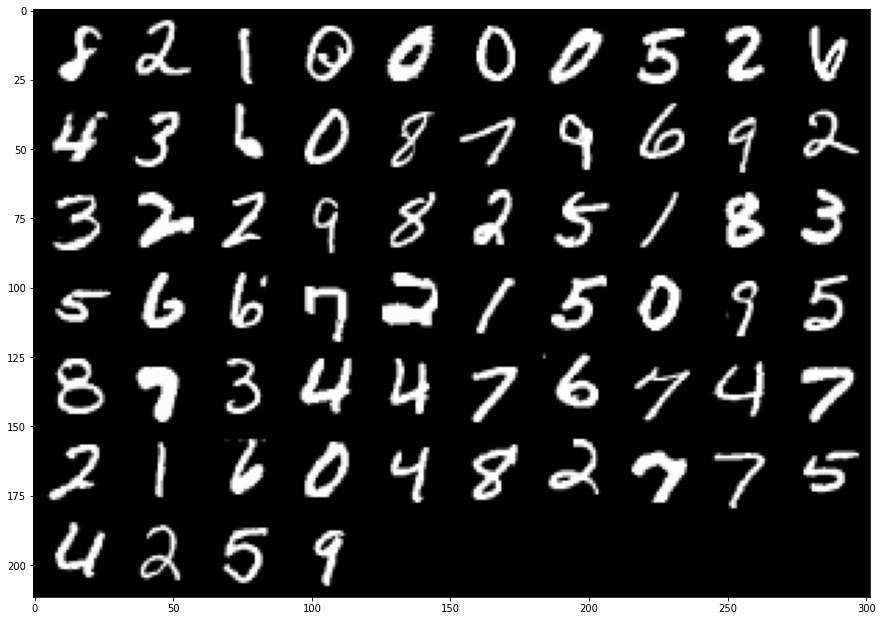

In [238]:

import numpy as np
import matplotlib.pyplot as plt
images, labels, _, _ = next(iter(mf_train_loader))
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 15))
plt.imshow(np.transpose(grid, (1,2,0)))


#Network Architecture
* Network:
  * 7 convolution layers
  * 2 fully connected layers
  * 2 max pooling layers
  * 7th conv layers will give 10 outputs so that concatenation with encoded random tensor will of same dimemsion
  * Adjusted padding so that 7th conv layer be give 10 outputs

* Concatination of the two inputs:
  * The output of the 7th conv layer contains the 10 tensor values of the MNIST image input.


In [239]:
class Network(nn.Module):
  def __init__(self):
    super().__init__() 
    # 1x28x28
    self.conv1 = nn.Conv2d(
        in_channels= 1,
        out_channels= 32,
        kernel_size= 3,
        padding=1
    ) # 32x28x28

    self.conv2 = nn.Conv2d(
        in_channels=32, 
        out_channels=64, 
        kernel_size=3,
        padding=1
    )  # 64x28x28

    self.max_pool1 = nn.MaxPool2d(2, 2) # 64x14x14
                     
    self.conv3 = nn.Conv2d(
        in_channels= 64, 
        out_channels= 128, 
        kernel_size= 3,
        padding=1
    )  # 128x14x14

    self.conv4 = nn.Conv2d(
        in_channels= 128, 
        out_channels= 256, 
        kernel_size= 3,
        padding=1
    )    # 256x14x14

    self.max_pool2 = nn.MaxPool2d(2, 2)  # 256x7x7
    
    self.conv5 = nn.Conv2d(
        in_channels= 256, 
        out_channels= 512, 
        kernel_size= 3
    )  # 512x5x5

    self.conv6 = nn.Conv2d(
        in_channels= 512, 
        out_channels= 1024, 
        kernel_size= 3
    )  # 1024x3x3

    self.conv7 = nn.Conv2d(
        in_channels= 1024, 
        out_channels= 10,
        kernel_size= 3
    )  # 10x1x1

    # out received from above layer is 10x1x1
    # send one hot encoded random vector
    # so total input features will become 20
    self.fc1 = nn.Linear(
        in_features= 20,
        out_features= 64
    )    

    self.fc2 = nn.Linear(
        in_features= 64,
        out_features= 19
    )


  def forward(self, mnist_image, random_number_vector):

    # conv1
    image = self.conv1(mnist_image)
    image = F.relu(image)
    # conv2
    image = self.conv2(image)
    image = F.relu(image)
    # maxpooling 1
    image = self.max_pool1(image)
    # conv3
    image = self.conv3(image)
    image = F.relu(image)
    # conv4
    image = self.conv4(image)
    image = F.relu(image)
    # maxpooling 2
    image = self.max_pool2(image)
    # conv5
    image = self.conv5(image)
    image = F.relu(image)
    # conv6
    image = self.conv6(image)
    image = F.relu(image)
    # conv7
    image = self.conv7(image)
    # Transforming the image tensor into 1 x 10.
    image = image.reshape(-1, 10) # 1x10
    # Clubbing the image convolution with the random number using torch.cat()
    combined_tensor = torch.cat((image,random_number_vector),dim= 1) # 1x20
    # fc1
    combined_tensor = self.fc1(combined_tensor)
    combined_tensor = F.relu(combined_tensor)
    # fc2
    combined_tensor = self.fc2(combined_tensor)
    # returns image predictions, sum_predictions
    return F.log_softmax(image), F.log_softmax(combined_tensor)

Instantiating the Network class with network

In [240]:
 network = Network()

Checking for GPU and if exists using it

In [241]:
# Use cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Moving the network to GPU

In [242]:
network.to(device)

Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(1024, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=19, bias=True)
)

Generating train and test loaders

Function to return correct number of predictions when given predictions and labels

In [244]:
def get_correct_preds(preds, labels):
  cp = preds.argmax(dim=1).eq(labels).sum().item()
  return cp

Deining the training and testing loops

In [246]:
def train(network, num_epochs, train_loader):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.01)
  
  # for number of epochs
  for epoch in range(num_epochs):
    # for each epoch
    total_image_loss = 0
    total_sum_loss = 0
    correct_sum_preds = 0
    correct_image_preds = 0
    
    # Iterate over the train loader 
    for i,batch in enumerate(train_loader):
      # Extracting images, labels, ohrs, sum_labels from each batch
      images, labels, ohrs, sum_labels = batch 
      # Sending images and random numbers to the network and recieving the outputs.
      preds_image, preds_sum = network(images, ohrs)
      
      # Loss calculation for both image and sum predictions
      image_loss = F.cross_entropy(preds_image, labels)
      sum_loss = F.cross_entropy(preds_sum, sum_labels)
      
      # Setting gradients to zero
      optimizer.zero_grad()
      
      # Calculating total loss for image and sum predictions
      total_image_loss += image_loss.item()
      total_sum_loss += sum_loss.item()

      # Calculating correct predictions of image and sum. 
      correct_image_preds += get_correct_preds(preds_image, labels)
      correct_sum_preds += get_correct_preds(preds_sum, sum_labels)
      
      # Backprop
      image_loss.backward(retain_graph=True)
      sum_loss.backward()
      
      # Updating the weights.
      optimizer.step()
      #print(f"{i}batch done")
    # Calculating the training and testing accuracy 
    img_train_acc = (correct_image_preds/60000)*100
    sum_train_acc = (correct_sum_preds/60000)*100
          

    print("epoch:", epoch,
            "Total image Loss:", total_image_loss ,
            "total_sum_loss:", total_sum_loss,
            "Correct image predictions:", correct_image_preds,
            "correct sum predictions:", correct_sum_preds,
            "Image Training accuracy:", img_train_acc,
            "sum Training accuracy:", sum_train_acc
            )
      


      

In [247]:
network = Network()
num_epochs = 10
train(network, num_epochs, mf_train_loader)

<ipython-input-239-b81bbd42bc0d>:97: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(image), F.log_softmax(combined_tensor)


epoch: 0 Total image Loss: 1780.301834821701 total_sum_loss: 2549.001699090004 Correct image predictions: 18355 correct sum predictions: 11434 Image Training accuracy: 30.59166666666667 sum Training accuracy: 19.056666666666665
epoch: 1 Total image Loss: 225.26900732703507 total_sum_loss: 1692.5029692649841 Correct image predictions: 55505 correct sum predictions: 24948 Image Training accuracy: 92.50833333333334 sum Training accuracy: 41.58
epoch: 2 Total image Loss: 111.83052811864763 total_sum_loss: 1439.2949695587158 Correct image predictions: 57814 correct sum predictions: 29323 Image Training accuracy: 96.35666666666667 sum Training accuracy: 48.87166666666667
epoch: 3 Total image Loss: 77.31614805862773 total_sum_loss: 1300.0065153241158 Correct image predictions: 58444 correct sum predictions: 32195 Image Training accuracy: 97.40666666666667 sum Training accuracy: 53.65833333333333
epoch: 4 Total image Loss: 60.68309888872318 total_sum_loss: 1186.649236381054 Correct image predi

KeyboardInterrupt: ignored

In [250]:
def test(network, test_loader):
      correct_image_preds = 0
      correct_sum_preds = 0
      for batch in test_loader:
        # Extracting images, labels, ohrs, sum_labels from each batch
        images, labels, ohrs, sum_labels = batch 

        # Sending images and random numbers to the network and recieving the outputs.
        preds_image, preds_sum = network(images, ohrs)

        # Calculating correct predictions of image and sum. 
        correct_image_preds += get_correct_preds(preds_image, labels)
        correct_sum_preds += get_correct_preds(preds_sum, sum_labels)

      print(
           
            "Correct image predictions:", correct_image_preds,
            "correct sum predictions:", correct_sum_preds,
            "Image Test accuracy:", (correct_image_preds/10000)*100 ,
            "sum Test accuracy:", (correct_sum_preds/10000)*100
            )


In [251]:
test(network, mf_test_loader)

<ipython-input-239-b81bbd42bc0d>:97: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(image), F.log_softmax(combined_tensor)


Correct image predictions: 9852 correct sum predictions: 832 Image Test accuracy: 98.52 sum Test accuracy: 8.32
